In [1]:
import pandas as pd, numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import dev_hiveplot.hiveplot as hp
from copy import copy
from importlib import reload

%matplotlib inline

## Read in HGNC Mapper

In [2]:
hgnc = pd.read_csv('../../data/hgnc_alias_list.txt', sep='\t')
hgnc.head()

,HGNC ID,Approved symbol,Approved name,Status,Previous symbols,Synonyms,Chromosome,Accession numbers,RefSeq IDs,NCBI Gene ID(supplied by NCBI),Ensembl ID(supplied by Ensembl),Rat genome database ID(supplied by RGD),Vega ID(supplied by Vega),OMIM ID(supplied by OMIM),RefSeq(supplied by NCBI),UCSC ID(supplied by UCSC),UniProt ID(supplied by UniProt),Mouse genome database ID(supplied by MGI),Name synonyms
0,HGNC:5,A1BG,alpha-1-B glycoprotein,Approved,NaN,NaN,19q13.43,NaN,NM_130786,1.0,ENSG00000121410,RGD:69417,OTTHUMG00000183507,138670,NM_130786,uc002qsd.5,P04217,MGI:2152878,NaN
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,Approved,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569,19q13.43,BC040926,NR_015380,503538.0,ENSG00000268895,NaN,OTTHUMG00000183508,NaN,NR_015380,uc002qse.3,NaN,NaN,NaN
2,HGNC:24086,A1CF,APOBEC1 complementation factor,Approved,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF",10q11.23,AF271790,NM_014576,29974.0,ENSG00000148584,RGD:619834,OTTHUMG00000018240,618199,NM_001198818,uc057tgv.1,Q9NQ94,MGI:1917115,NaN
3,HGNC:6,A1S9T~withdrawn,"symbol withdrawn, see UBA1",Symbol Withdrawn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HGNC:7,A2M,alpha-2-macroglobulin,Approved,NaN,"FWP007, S863-7, CPAMD5",12p13.31,"BX647329, X68728, M11313",NM_000014,2.0,ENSG00000175899,RGD:2004,OTTHUMG00000150267,103950,NM_000014,uc001qvk.2,P01023,MGI:2449119,NaN


In [3]:
hgnc = hgnc[hgnc['Approved symbol'].apply(lambda x: 'withdrawn' not in x)]

# get the original keys
hgnc_original_keys = hgnc['Approved symbol'].unique()

# drop a lot of columns for efficiency
hgnc = hgnc[list(hgnc.columns)[0:6]].drop('Status', axis=1)

# filter out Nan synonyms (not helpful)
hgnc_syn_list = hgnc[~ hgnc.Synonyms.isna()]
hgnc_prev_symb_list = hgnc[~ hgnc['Previous symbols'].isna()]

print(hgnc_syn_list.shape)
print(hgnc_syn_list.columns)
display(hgnc_syn_list.head())

print(hgnc_prev_symb_list.shape)
print(hgnc_prev_symb_list.columns)
display(hgnc_prev_symb_list.head())

(21435, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
2,HGNC:24086,A1CF,APOBEC1 complementation factor,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF"
4,HGNC:7,A2M,alpha-2-macroglobulin,NaN,"FWP007, S863-7, CPAMD5"
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"


(11702, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
9,HGNC:8,A2MP1,alpha-2-macroglobulin pseudogene 1,A2MP,NaN
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"
13,HGNC:18149,A4GALT,"alpha 1,4-galactosyltransferase (P blood group)",P1,"A14GALT, Gb3S, P(k)"


In [4]:
#convert the synonyms column to a list
# convert these lists to pd.Series
# merge with original dataframe
#drop old synonyms column 
# melt the new columns into rows


current_syn_list = hgnc_syn_list.Synonyms.apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(["Synonyms"], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols'], value_name = "synonym") 

current_syn_list = current_syn_list[~ current_syn_list.synonym.isna()]
current_syn_list.synonym = current_syn_list.synonym.apply(lambda x: x.replace(' ',''))


current_syn_list.head()

,HGNC ID,Approved symbol,Approved name,Previous symbols,variable,synonym
0,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",0,FLJ23569
1,HGNC:24086,A1CF,APOBEC1 complementation factor,NaN,0,ACF
2,HGNC:7,A2M,alpha-2-macroglobulin,NaN,0,FWP007
3,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,0,FLJ25179
4,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,0,IGBS3S


In [5]:
prev_symb_list = hgnc_prev_symb_list['Previous symbols'].apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(['Previous symbols'], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Synonyms'], value_name = "synonym") 

prev_symb_list = prev_symb_list[~ prev_symb_list.synonym.isna()]
prev_symb_list.synonym = prev_symb_list.synonym.apply(lambda x: x.replace(' ',''))


prev_symb_list.head()

,HGNC ID,Approved symbol,Approved name,Synonyms,variable,synonym
0,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,FLJ23569,0,NCRNA00181
1,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,"FLJ25179, p170",0,CPAMD9
2,HGNC:8,A2MP1,alpha-2-macroglobulin pseudogene 1,NaN,0,A2MP
3,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2","IGBS3S, IGB3S",0,A3GALT2P
4,HGNC:18149,A4GALT,"alpha 1,4-galactosyltransferase (P blood group)","A14GALT, Gb3S, P(k)",0,P1


In [6]:
hgnc_mapper = dict(zip(current_syn_list['synonym'], current_syn_list['Approved symbol']))
hgnc_mapper_previous = dict(zip(prev_symb_list['synonym'], prev_symb_list['Approved symbol']))

In [7]:
trouble_list = list(filter(lambda x: hgnc_mapper[x] != hgnc_mapper_previous[x], set(hgnc_mapper.keys())&set(hgnc_mapper_previous.keys())))

louvain_tier1 = pd.read_csv('../../results/louvain_clusters.txt', sep='\t')
for n in louvain_tier1.names:
    if (n in trouble_list):
        print(n)

RAGE


In [8]:
hand_coded = {'RAGE':'MOK', 'SGK2':'SGK2', 'SGK196':'SGK196'}

In [9]:
hgnc_mapper_previous.update(hgnc_mapper) #overwrite the previous symbol conflicts

hgnc_mapper = hgnc_mapper_previous
hgnc_mapper.update({x:x for x in hgnc_original_keys}) #keep the identify maps
hgnc_mapper.update(hand_coded) # overwrite the trouble list

## Create Louvain clusters

In [10]:
louvain_tier2 = pd.read_csv('../../results/louvain_small_clusters.txt', sep='\t')
louv= louvain_tier1.merge(louvain_tier2.set_index('names'), how='left', on='names', suffixes=['_super', '_sub'])
louv.names = louv.names.apply(lambda x: hgnc_mapper[x])
louv.head()

,names,cluster_super,cluster_sub
0,PAK1,5,3
1,ERBB2,5,18
2,MST1R,5,18
3,YES1,5,18
4,TYRO3,5,18


## Read in the Graph for connectivity

In [11]:
graph_edges = pd.read_csv('../../data/KIN_edges_no_weights.txt', sep='\t', header=None)
graph_edges[0] = copy(graph_edges[0].apply(lambda x: hgnc_mapper[x]))
graph_edges[1] = copy(graph_edges[1].apply(lambda x: hgnc_mapper[x]))
graph_edges.head()

,0,1
0,PAK1,ERBB2
1,MST1R,YES1
2,TYRO3,YES1
3,LYN,KIT
4,PRKCA,KIT


In [12]:
graph_edges_duplicate = copy(graph_edges)
graph_edges_duplicate.columns = [1,0]
graph_edges_duplicate = graph_edges_duplicate[[0,1]]

graph_edges_extended= graph_edges.append(graph_edges_duplicate)

In [13]:
graph_edge_dict = graph_edges_extended.groupby(0).agg(lambda x: set(x)).to_dict()[1]
graph_edge_dict.update({x:y|set([x]) for x,y in graph_edge_dict.items()})# make reflexive
graph_edge_dict

{'AATK': {'AATK', 'CDK5', 'STK39'},
 'ABL1': {'ABL1',
  'ABL2',
  'ATM',
  'ATR',
  'BMP2K',
  'BTK',
  'CDK1',
  'CDK5',
  'CDKL5',
  'CLK1',
  'CLK4',
  'EGFR',
  'EPHA1',
  'EPHA3',
  'EPHA4',
  'EPHA5',
  'EPHA7',
  'EPHA8',
  'EPHB2',
  'EPHB3',
  'EPHB6',
  'ERBB2',
  'ERBB3',
  'ERBB4',
  'FYN',
  'HCK',
  'HIPK2',
  'JAK1',
  'JAK2',
  'KIT',
  'LATS2',
  'LRRK1',
  'LRRK2',
  'LYN',
  'MAP3K8',
  'MAP4K1',
  'MAP4K5',
  'MAPK1',
  'MAPK11',
  'MAPK12',
  'MAPK14',
  'MAPK3',
  'MET',
  'MTOR',
  'MYLK',
  'NEK8',
  'NTRK1',
  'NTRK2',
  'NTRK3',
  'PAK2',
  'PDGFRB',
  'PDK1',
  'PKM',
  'PRKCD',
  'PRKCZ',
  'PRKD1',
  'PRKDC',
  'ROS1',
  'SRC',
  'SRPK2',
  'STK3',
  'STK4',
  'SYK',
  'TTK',
  'UHMK1',
  'WNK2',
  'YES1',
  'ZAP70'},
 'ABL2': {'ABL1',
  'ABL2',
  'EGFR',
  'EPHB2',
  'ERBB2',
  'ERBB3',
  'ERBB4',
  'FYN',
  'HCK',
  'JAK1',
  'KIT',
  'LRRK2',
  'MAP3K10',
  'MET',
  'PDGFRB',
  'PKM',
  'SRC'},
 'ACVR1': {'ACVR1',
  'ACVR1B',
  'ACVR1C',
  'ACVR2A',
  'A

## Drug targeting

In [14]:
drug_data = pd.read_excel('../../data/Klaeger_Science_2017 Supplementary Table 6 Selectivities.xlsx', sheet_name='CATDS target')
drug_data.head()

,Drug,Target,At,CATDS
0,MK-5108,AURKA,0.120921,0.657165
1,PF-477736,CHEK1,0.243725,0.733257
2,Dovitinib,FLT3,0.265240,0.860803
3,Silmitasertib,CSNK2A1;CSNK2A3,0.309017,0.508172
4,Capmatinib,MET,0.337514,1.000000


In [15]:
drug_list = list(sorted(set(drug_data.Drug)))
len(drug_list)

222

In [16]:
# filter to only hgnc keys
drug_data = drug_data[drug_data.Target.isin(hgnc_mapper.keys())]

double_drug_targets = drug_data[drug_data['Target'].apply(lambda x: ';' in x)]
#double_drug_targets.shape

first_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[0])
second_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[1])

repaired_double_targets = double_drug_targets.drop('Target', axis=1).assign(**{'Target':first_genes})
repaired_double_targets = repaired_double_targets.append(double_drug_targets.drop('Target', axis=1).assign(**{'Target':second_genes})) 
#repaired_double_targets = repaired_double_targets[cols_to_keep]

drug_data = drug_data.drop(double_drug_targets.index).append(repaired_double_targets)

# convert to hgnc
drug_data.Target = drug_data.Target.apply(lambda x: hgnc_mapper[x])

# sort columns
drug_data = drug_data[['Target', 'Drug', 'At', 'CATDS']]
drug_data.head()


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Target,Drug,At,CATDS
0,AURKA,MK-5108,0.120921,0.657165
1,CHEK1,PF-477736,0.243725,0.733257
2,FLT3,Dovitinib,0.265240,0.860803
4,MET,Capmatinib,0.337514,1.000000
5,MAPKAPK2,VX-702,0.342705,0.743594


In [17]:
# filter to kinases present
drug_data = drug_data[drug_data.Target.isin(set(louv['names']))]

# create dicts to map cluster numbers
gene_to_sub_mapper = louv.set_index('names')['cluster_sub'].to_dict()
gene_to_super_mapper = louv.set_index('names')['cluster_super'].to_dict() 

drug_data['cluster_sub'] = drug_data.Target.apply(lambda x: gene_to_sub_mapper[x])
drug_data['cluster_super'] = drug_data.Target.apply(lambda x: gene_to_super_mapper[x])

drug_data.head()

,Target,Drug,At,CATDS,cluster_sub,cluster_super
0,AURKA,MK-5108,0.120921,0.657165,6,4
1,CHEK1,PF-477736,0.243725,0.733257,6,4
2,FLT3,Dovitinib,0.265240,0.860803,9,2
4,MET,Capmatinib,0.337514,1.000000,18,5
5,MAPKAPK2,VX-702,0.342705,0.743594,11,3


In [18]:
louv[louv.cluster_sub==7]

,names,cluster_super,cluster_sub
106,TGFBR2,1,7
107,TGFBR1,1,7
108,AMHR2,1,7
109,ACVRL1,1,7
202,TSSK1B,1,7
218,DAPK2,1,7
235,STK35,1,7
237,CDKL1,1,7
241,MYO3A,1,7
242,TSSK4,1,7


In [19]:
louv.groupby('cluster_sub').count()

,names,cluster_super
cluster_sub,,
1,2,2
2,30,30
3,8,8
4,41,41
5,8,8
6,88,88
7,12,12
8,8,8
9,18,18


In [20]:
louv[louv.cluster_super==1]

,names,cluster_super,cluster_sub
63,BMPR2,1,8
106,TGFBR2,1,7
107,TGFBR1,1,7
108,AMHR2,1,7
109,ACVRL1,1,7
110,BMPR1B,1,8
137,STK39,1,26
147,BMPR1A,1,8
156,ACVR2B,1,8
157,ACVR1B,1,8


In [21]:
for i in range(9):
    print(louv[louv.cluster_super==i].shape)

(0, 3)
(27, 3)
(75, 3)
(58, 3)
(151, 3)
(102, 3)
(5, 3)
(51, 3)
(4, 3)


In [22]:
louv[louv.cluster_sub==6]#.shape

,names,cluster_super,cluster_sub
16,ATR,4,6
21,PRKDC,4,6
77,PKM,4,6
88,TTN,4,6
89,WEE1,4,6
90,CSNK2A1,4,6
95,ATM,4,6
96,MOS,4,6
124,PBK,4,6
166,TRIM24,4,6


## Create the Hive Plot

In [23]:
sub_clust_no = 6
super_clust_no = 4

nodes = {}
nodes['kinome'] = [('kinome_'+x,x) for x in louv.names]
nodes['drug'] = [('drug_'+x,x) for x in drug_list]
nodes['sub'] = [('sub_'+x,x) for x,z in zip(louv.names, louv.cluster_sub) if z == sub_clust_no]
nodes['super'] = [('super_'+x,x) for x,y in zip(louv.names, louv.cluster_super) if y == super_clust_no]
for group in nodes.keys():
    sorted_nodes = [x for x,d in sorted(nodes[group], key = lambda x: x[1])]

# get the supercluster genes
louv_super_names = set(louv[louv.cluster_super == super_clust_no].names)
drug_sub_hits = copy(drug_data[drug_data.cluster_sub == sub_clust_no])
present_drug_set = set(drug_sub_hits.Drug)
present_drug_list = list(present_drug_set)

# compute mean CATDS
mean_drug_catds = drug_sub_hits.groupby('Drug')['CATDS'].mean().to_dict()

# sort present drugs by catds
try:
    sorted_present_drugs, ___ = zip(*sorted(zip(present_drug_list, [mean_drug_catds[x] for x in present_drug_list]), key = lambda x: x[1]))
except:
    sorted_present_drugs = []
    
sorted_present_drugs = list(sorted_present_drugs)

# sort the drugs by 1) presence 2) selectivity
drugs_not_present = list(set(drug_list) - set(present_drug_set))

#nodes.update({'drug':[('drug_'+x,x) for x in drugs_not_present + sorted_present_drugs]})
nodes.update({'drug':[('drug_'+x,x) for x in list(reversed(sorted_present_drugs)) + drugs_not_present]})

# calculate total drug hits of present drugs
total_drug_hits = drug_data[drug_data.Drug.isin(present_drug_set)]
total_drug_hit_sets = total_drug_hits.groupby('Drug')['Target'].agg(lambda x: set(x)).to_dict()
    
edges = {}
edges['sub_super'] = [(sub_node,('super_'+super_node, super_node),1) for sub_node in nodes['sub'] for super_node in graph_edge_dict[sub_node[1]] if super_node in louv_super_names]
edges['super_kinome'] = [(super_node,('kinome_'+kin_node, kin_node),1) for super_node in nodes['super'] for kin_node in graph_edge_dict[super_node[1]]]
edges['sub_kinome'] = [(('super_'+sub_node[1],sub_node[1]),('kinome_'+kin_node, kin_node),1) for sub_node in nodes['sub'] for kin_node in graph_edge_dict[sub_node[1]]]
edges['drug_sub'] = [(('drug_'+drug,drug), ('sub_'+target,target), at_value) for drug,target,at_value in zip(drug_sub_hits.Drug, drug_sub_hits.Target, -np.log(drug_sub_hits.At.values))]
edges['drug_kin'] = [(('drug_'+drug,drug), ('kinome_'+kin_node,kin_node), 1) for drug in sorted_present_drugs for kin_node in total_drug_hit_sets[drug]]

# filter the sub_kinome connections from the super_kinome connections
edges['super_kinome'] = list(filter(lambda x: x not in edges['sub_kinome'], edges['super_kinome']))

nodes_cmap = dict()
nodes_cmap['kinome'] = 'green'
nodes_cmap['drug'] = 'gray'
nodes_cmap['sub'] = 'blue'
nodes_cmap['super'] = 'blue'

edges_cmap = dict()
edges_cmap['sub_super'] = 'blue'
edges_cmap['sub_kinome'] = 'orange'
edges_cmap['super_kinome'] = 'black'
edges_cmap['drug_sub'] = 'red'
edges_cmap['drug_kin'] = 'gray'

#nodes['super']
#edges['sub_connectivity']
#edges['super_connectivity']

## Reload the development HivePlot package and build a hiveplot

In [24]:
# size comparison
d, k, S, s = (len(drug_list),len(louv.names.unique()), len(louv_super_names), len(nodes['sub']))

print('Post-log sizes: ')
print('Drugs: ',(np.log(d)+1))
print('Kinome: ', (np.log(k)+1))
print('Supercluster: ', (np.log(S)+1))
print('subcluster: ', (np.log(s)+1))
print()

d, k, S, s = list(map(lambda x:(np.log(x)+1)/x, [d, k, S, s]))

print('Scaling factor: ')
print('Drugs: ',d)
print('Kinome: ', k)
print('Supercluster: ', S)
print('subcluster: ', s)

Post-log sizes: 
Drugs:  6.402677381872279
Kinome:  7.159095388491933
Supercluster:  6.017279836814924
subcluster:  5.477336814478207

Scaling factor: 
Drugs:  0.02884088910753279
Kinome:  0.015135508220913177
Supercluster:  0.03984953534314519
subcluster:  0.062242463800888714


In [25]:
group_scale = {}
group_scale['kinome'] = k/s
group_scale['super'] = S/s
group_scale['drug'] = d/s
group_scale['sub'] = 1.0

In [26]:
group_scale

{'kinome': 0.24317013332459164,
 'super': 0.6402306867321697,
 'drug': 0.46336355192804873,
 'sub': 1.0}

In [27]:
for group_len, g_s in zip((len(louv.names.unique()), len(louv_super_names), len(drug_list), len(nodes['sub'])), group_scale.values()): 
    print(group_len * g_s)
    

115.01947306253184
96.67483369655761
102.86670852802682
88.0


In [28]:
group_reverse = {}
group_reverse['kinome'] = False
group_reverse['super'] = True
group_reverse['drug'] = True
group_reverse['sub'] = True

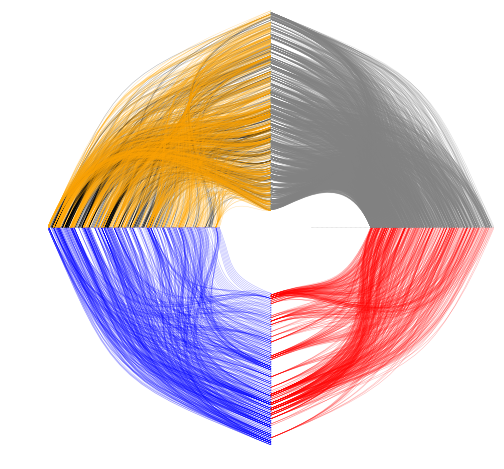

In [29]:
reload(hp)
h = hp.HivePlot(nodes, edges, nodes_cmap, edges_cmap, group_scale=group_scale, reverse_to_expand=group_reverse, skip_within=True)
h.draw()
#plt.savefig('temp.pdf')

## Functionalized plotting and coloring

In [30]:
understudied = pd.read_csv('../../data/understudied_kinases.csv', header=None)[0]

# these are just case sensitive values, no new stuff
hgnc_mapper.update({'SGK110':'SBK3', 'SGK223':'PRAG1', 'SGK494':'RSKR'})

understudied = set(understudied.apply(lambda x: hgnc_mapper[x.replace(' ','')]))

In [31]:
louv[louv.cluster_sub==6]

,names,cluster_super,cluster_sub
16,ATR,4,6
21,PRKDC,4,6
77,PKM,4,6
88,TTN,4,6
89,WEE1,4,6
90,CSNK2A1,4,6
95,ATM,4,6
96,MOS,4,6
124,PBK,4,6
166,TRIM24,4,6


In [32]:
len(louv[louv.cluster_sub == 6])

88

In [59]:
def plot_sub_super_hiveplot(sub_clust_no, super_clust_no, fig, ax):
    nodes = {}
    nodes['kinome'] = [('kinome_'+x,x) for x in louv.names]
    nodes['drug'] = [('drug_'+x,x) for x in drug_list]
    
    super_cluster_size = len(louv[louv.cluster_super == super_clust_no])
    sub_cluster_size = len(louv[louv.cluster_sub == sub_clust_no])
    superkinase_to_sub_clust_id_dict = louv[louv.cluster_super == super_clust_no].set_index('names').cluster_sub.to_dict()

    # add the understudied kinases last, as we reverse
    nodes['sub'] = [('sub_'+x,x,'well') for x,z in zip(louv.names, louv.cluster_sub) if z == sub_clust_no and x not in understudied]
    nodes.update({'sub':nodes['sub']+[('sub_empty'+str(i),'empty'+str(i),'empty') for i in range(0,sub_cluster_size//20+1)]}) # add empty divider proportiona to length
    nodes.update({'sub':nodes['sub']+[('sub_'+x,x,'under') for x,z in zip(louv.names, louv.cluster_sub) if z == sub_clust_no and x in understudied]})
    
    #print(nodes['sub'])
    nodes['super'] = []
    set_of_subclusts_in_superclust = list(louv[louv.cluster_super == super_clust_no].cluster_sub.unique())
    sub_clust_id_dict = {x:y for y,x in enumerate(set_of_subclusts_in_superclust)}
    
    for i, sub_clust_in_super in enumerate(set_of_subclusts_in_superclust):
        #print(i)
        nodes.update({'super':nodes['super']+[('super_'+x,x,i) for x,y,z in zip(louv.names, louv.cluster_super, louv.cluster_sub) if y == super_clust_no and z == sub_clust_in_super]+[('super_empty'+str(i),'empty'+str(i),'empty')]})

    # get the supercluster genes
    louv_super_names = set(louv[louv.cluster_super == super_clust_no].names)
    drug_sub_hits = copy(drug_data[drug_data.cluster_sub == sub_clust_no])
    present_drug_set = set(drug_sub_hits.Drug)
    present_drug_list = list(present_drug_set)

    # compute mean CATDS
    mean_drug_catds = drug_sub_hits.groupby('Drug')['CATDS'].mean().to_dict()

    # sort present drugs by catds
    try:
        sorted_present_drugs, ___ = zip(*sorted(zip(present_drug_list, [mean_drug_catds[x] for x in present_drug_list]), key = lambda x: x[1]))
    except:
        sorted_present_drugs = []

    sorted_present_drugs = list(sorted_present_drugs)

    # sort the drugs by 1) presence 2) selectivity
    drugs_not_present = list(set(drug_list) - set(present_drug_set))

    #nodes.update({'drug':[('drug_'+x,x) for x in drugs_not_present + sorted_present_drugs]})
    nodes.update({'drug':[('drug_'+x,x) for x in list(reversed(sorted_present_drugs)) + drugs_not_present]})

    # calculate total drug hits of present drugs
    total_drug_hits = drug_data[drug_data.Drug.isin(present_drug_set)]
    total_drug_hit_sets = total_drug_hits.groupby('Drug')['Target'].agg(lambda x: set(x)).to_dict()

    edges = {}
    edges['sub_super'] = [(sub_node,('super_'+super_node, super_node, sub_clust_id_dict[superkinase_to_sub_clust_id_dict[super_node]]),1) for sub_node in nodes['sub'] if 'empty' != sub_node[2] for super_node in graph_edge_dict[sub_node[1]] if super_node in louv_super_names]
    edges['super_kinome'] = [(super_node,('kinome_'+kin_node, kin_node),1) for super_node in nodes['super'] if super_node[2] != 'empty' for kin_node in graph_edge_dict[super_node[1]]]
    edges['sub_kinome'] = [(('super_'+sub_node[1],sub_node[1], sub_clust_id_dict[superkinase_to_sub_clust_id_dict[sub_node[1]]]),('kinome_'+kin_node, kin_node),1) for sub_node in nodes['sub'] if 'empty' != sub_node[2] for kin_node in graph_edge_dict[sub_node[1]]]
    
    # create understudied status dict for drug_sub hits
    understudied_status_dict = {x:'well' for x,z in zip(louv.names, louv.cluster_sub) if z == sub_clust_no and x not in understudied}
    understudied_status_dict.update({x:'under' for x,z in zip(louv.names, louv.cluster_sub) if z == sub_clust_no and x in understudied})
    
    edges['drug_sub'] = [(('drug_'+drug,drug), ('sub_'+target,target,understudied_status_dict[target]), at_value) for drug,target,at_value in zip(drug_sub_hits.Drug, drug_sub_hits.Target, -np.log(drug_sub_hits.At.values))]
    edges['drug_kin'] = [(('drug_'+drug,drug), ('kinome_'+kin_node,kin_node), 1) for drug in sorted_present_drugs for kin_node in total_drug_hit_sets[drug]]

    #print(edges['drug_sub'])
    
    # filter the sub_kinome connections from the super_kinome connections
    edges['super_kinome'] = list(filter(lambda x: x not in edges['sub_kinome'], edges['super_kinome']))

    nodes_cmap = dict()
    nodes_cmap['kinome'] = 'green'
    nodes_cmap['drug'] = 'gray'
    
    sub_color_dict = {'empty':'white', 'under':'green', 'well':'black'}
    nodes_cmap['sub'] = lambda x: sub_color_dict[x[2]]
    
    #print(len(set_of_subclusts_in_superclust))
    #len(set_of_subclusts_in_superclust)*1.0
    nodes_cmap['super'] = lambda x: cm.jet(x[2]*1.0/(len(set_of_subclusts_in_superclust)*1.0)) if x[2] != 'empty' else 'white'

    edges_cmap = dict()
    edges_cmap['sub_super'] = lambda x: 'blue' if x[0][2] is 'under' else 'gray'
    edges_cmap['sub_kinome'] = 'orange'
    edges_cmap['super_kinome'] = 'black'
    edges_cmap['drug_sub'] = 'red'
    edges_cmap['drug_kin'] = lambda x: 'purple' if x[1][1] not in understudied else 'red'

    group_scale = {}
    group_scale['kinome'] = k/s
    group_scale['super'] = S/s
    group_scale['drug'] = d/s
    group_scale['sub'] = 1.0
    
    group_reverse = {}
    group_reverse['kinome'] = False
    group_reverse['super'] = True
    group_reverse['drug'] = True
    group_reverse['sub'] = True
    
    #return
    #print(nodes['super'])
    
    h = hp.HivePlot(nodes, edges, nodes_cmap, edges_cmap, fig=fig, ax=ax, group_scale=group_scale, reverse_to_expand=group_reverse, skip_within=True)
    h.draw()
    
    return h


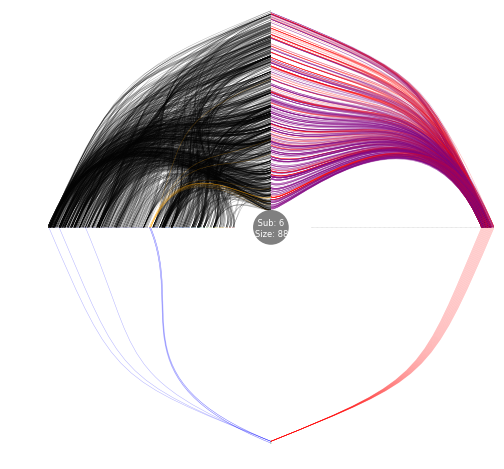

In [73]:
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(8,8))

#h = hp.HivePlot(nodes, edges, nodes_cmap, edges_cmap, fig=fig, ax=ax, group_scale=group_scale, reverse_to_expand=group_reverse, skip_within=True)
h = plot_sub_super_hiveplot(sub_clust_no=1, super_clust_no=4, fig=fig, ax=ax)

circle = plt.Circle(xy=(0, 0), radius=100,
                                color='gray', linewidth=0)
ax.add_patch(circle)

ax.text(x=-90,y=-50, s=' Sub: 6\nSize: 88',color='white',fontsize='small')
#h.draw()
plt.savefig('subc_8.pdf')

In [62]:
louv.groupby('cluster_super')['cluster_sub'].agg(lambda x: set(x))

cluster_super
1                                           {8, 26, 7}
2                                   {4, 9, 10, 20, 21}
3                                             {11, 12}
4    {32, 1, 34, 36, 6, 13, 14, 15, 16, 17, 23, 24,...
5                           {35, 3, 5, 18, 25, 29, 31}
6                                                 {19}
7                                          {33, 2, 22}
8                                                 {30}
Name: cluster_sub, dtype: object

In [66]:
sub_size_mapper = louv.groupby('cluster_sub').count()['names'].to_dict()
sub_size_mapper

{1: 2,
 2: 30,
 3: 8,
 4: 41,
 5: 8,
 6: 88,
 7: 12,
 8: 8,
 9: 18,
 10: 2,
 11: 23,
 12: 35,
 13: 27,
 14: 2,
 15: 2,
 16: 4,
 17: 4,
 18: 60,
 19: 5,
 20: 5,
 21: 9,
 22: 4,
 23: 2,
 24: 5,
 25: 8,
 26: 7,
 27: 4,
 28: 2,
 29: 2,
 30: 4,
 31: 2,
 32: 5,
 33: 17,
 34: 2,
 35: 14,
 36: 2}

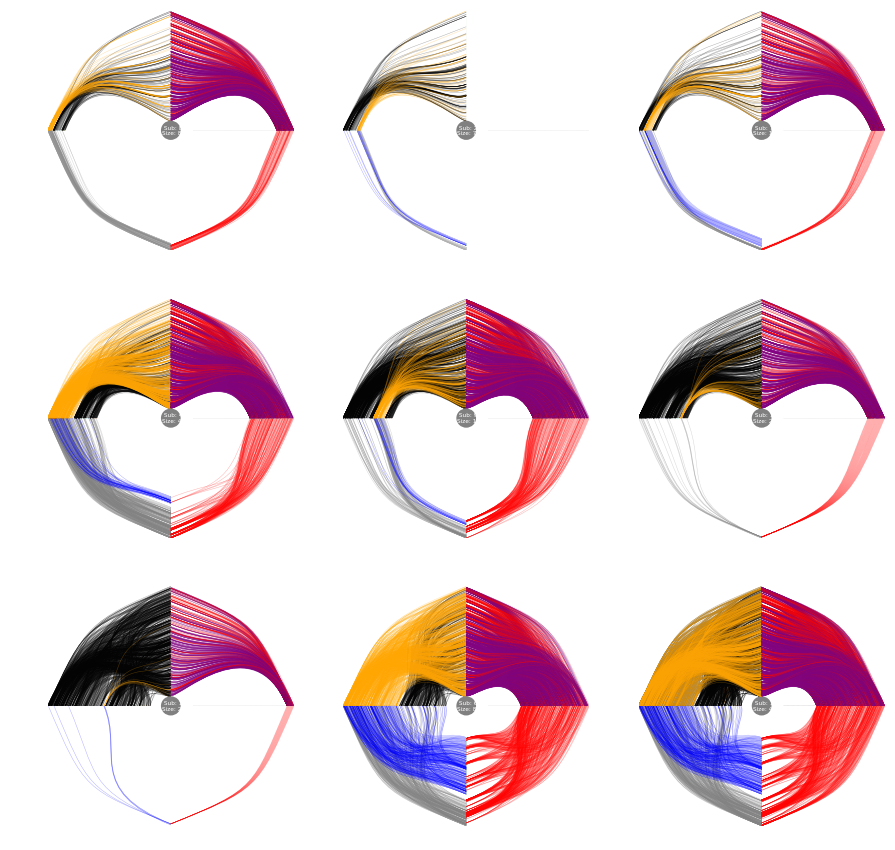

In [75]:
fig, axes = plt.subplots(ncols=3,nrows=3, figsize=(15,15))

super_sub_picks = {1:[8,26,7],2:[4,9,10],4:[1,6,17]}

plot_count = 0
for sup_ in super_sub_picks.keys():
    for sub_ in super_sub_picks[sup_]:
        ax = axes[plot_count//3][plot_count%3]
        
        plot_sub_super_hiveplot(sub_clust_no=sub_, super_clust_no=sup_, fig=fig, ax=ax)    
        plot_count+=1
        circle = plt.Circle(xy=(0, 0), radius=100,
                                color='gray', linewidth=0)
        ax.add_patch(circle)
        
        ax.text(x=-90,y=-50, s=' Sub: '+str(sub_)+'\nSize: '+str(sub_size_mapper[sub_]),color='white',fontsize='xx-small')

#h = hp.HivePlot(nodes, edges, nodes_cmap, edges_cmap, fig=fig, ax=ax, group_scale=group_scale, reverse_to_expand=group_reverse, skip_within=True)
h = plot_sub_super_hiveplot(sub_clust_no=6, super_clust_no=4, fig=fig, ax=ax)


#h.draw()
plt.savefig('multiple_hive.pdf')

In [ ]:
print(len(drug_data.Target.unique()))
raw_drug_data = pd.read_excel('../../data/Klaeger_Science_2017 Supplementary Table 6 Selectivities.xlsx', sheet_name='CATDS target')

print(len(raw_drug_data.Target.unique()))

In [36]:
kinobead = pd.read_excel('../../data/Klaeger_Science_2017 Supplementary Table 2 Target Lists.xlsx', sheet_name='Kinobeads')
kinobead.head()

,Drug,Lysate,Beads,Gene Name,Relative Intensity DMSO,Relative Intensity 3 nM,Relative Intensity 10 nM,Relative Intensity 30 nM,Relative Intensity 100 nM,Relative Intensity 300 nM,...,Bottom,Top,Inflection,EC50,EC50 Standard Error,Correction Factor,Apparent Kd,R2,BIC,Target Classification
0,Abemaciclib,4 cell line mix,Kinobeads,AAK1,1,0.905556,0.791054,0.738292,0.639565,0.323354,...,0.009092,0.957905,151.288760,151.288760,45.696999,0.673073,101.828368,0.985386,-20.503519,High confidence
1,Abemaciclib,4 cell line mix,Kinobeads,ADCK1,1,1.045974,0.869866,1.141565,0.000000,0.000000,...,-0.001200,1.014355,63.935536,63.935536,68.832970,0.622595,39.805937,0.983520,-12.606135,High confidence
2,Abemaciclib,4 cell line mix,Kinobeads,BMP2K,1,1.101696,1.012297,1.087891,0.973740,0.863230,...,-1.003278,1.034558,84774.108960,84774.108960,217756.243215,0.660952,56031.642989,0.937247,-15.330485,High confidence
3,Abemaciclib,4 cell line mix,Kinobeads,CAMK2D,1,0.894551,0.984481,0.900583,0.440384,0.178266,...,0.018690,0.972850,95.373379,95.373379,12.131433,0.203913,19.447883,0.992088,-22.486948,High confidence
4,Abemaciclib,4 cell line mix,Kinobeads,CAMK2G,1,1.125435,1.565245,1.236451,0.315507,0.139777,...,0.043265,1.232332,82.363844,82.363844,NaN,0.217204,17.889794,0.939239,1.734623,High confidence


In [37]:
len(kinobead['Gene Name'].unique())

520

In [38]:
[x for x,y in hgnc_mapper.items() if y == 'STK39']

['DCHT', 'SPAK', 'STK39']